Thinking about the possibility of catching a disease, it is natural to divide the corresponding population heterogeneity into "social" and "biological" parts.

Same is true for the heterogeneity of spreading the disease. A person's ability to spread the disease depends on her social life (activity, frequency of being in crowded places, etc) and her "bioligical" properties like how often does she cough during illness. As for the latter, I do not currently see how to simulate the dymamics of heterogeneity of spreading in "biological" part. On the other hand, the non-trivial dynamics of the "social" part can be modeled on the assumption that "social" heterogeneity in the ability to catch the disease and "social" heterogeneity in the ability to spread the disease are controlled by the same factors and thus can be regarded as the identical heterogeneities.

Below I model the dynamic of "social" heterogeneity in the ability to catch and spread the disease togeter with the dynamic of "biological" heterogeneity in the ability to catch (but not spread) the disease for the SIR model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scst
import scipy.special as scsp
import scipy.interpolate as scint
from scipy.integrate import odeint
import matplotlib.ticker as ticker
from dataclasses import dataclass
plt.rc('legend',fontsize=12, handlelength=2) # using a size in points

plt.style.use('seaborn-darkgrid')

For the beginning I repeat the SIR model with heterogenity of getting infected (HC SIR from now on) from previous part. HC SIR model heterogenity is described by lognormal distribution with initial (logarithmic) variance parameter $v_0$. HC SIR equations are
$$\begin{align}
& r_0= \alpha\, M(\mu,v), \\[3pt]
& \frac{d S}{dt}=- r_0 I\,S, \\[3pt]
& \frac{dI}{dt} =- \frac{dS}{dt}- I,\\[3pt]
& \frac{d\mu}{dt}=- r_0 I\,v, \\[3pt]
& \frac{d v}{dt}=-r_0 I\,v^2, \\[3pt]
&R = 1-S-I
\end{align}$$
$$I(0)=I_0,\:S(0)=1-I_0,\:\mu(0)=0,\:v(0)=v_0,\: \alpha=\frac{r_0(0)}{M(0,v_0)}$$ 
where $M(\mu,v)$ - expectation of lognormal variable
$M(\mu,v)=\exp(\mu+v/2)$

In [2]:
modeling_period=8.0
t_step=0.005
m_t=np.arange(0.0, modeling_period+t_step, t_step,dtype=np.float64)
n_steps=len(m_t)-1

def M(mu,v):return np.exp(mu+0.5*v)

Function to solve HC SIR equations is rather straightforward. It calculates $S$usceptible,$I$nfectious,$R$ecovered proportion values and also infection rate $|dS|$

In [3]:
def HC_SIR(r0_0,I0,v0):
    '''
    Heterogeneous in Catching
    SIR model
    '''
    α=r0_0/M(0.0,v0)
    
    def ODE(y,t):
        S,I,mu,v=y

        minus_r0_mult_I=-α*M(mu,v)*I

        dS = minus_r0_mult_I*S
        dI = -dS - I
        dmu = minus_r0_mult_I*v
        dv = dmu*v
        return [dS, dI, dmu, dv]
    
    y0=[1.0-I0,I0,0.0,v0]
    
    sol = odeint(ODE,y0, m_t).T
    dS=-ODE(sol,m_t)[0]
    S,I,mu,v=sol
    R=1.0-S-I
    
    return S,I,R,dS

And now see the dynamics

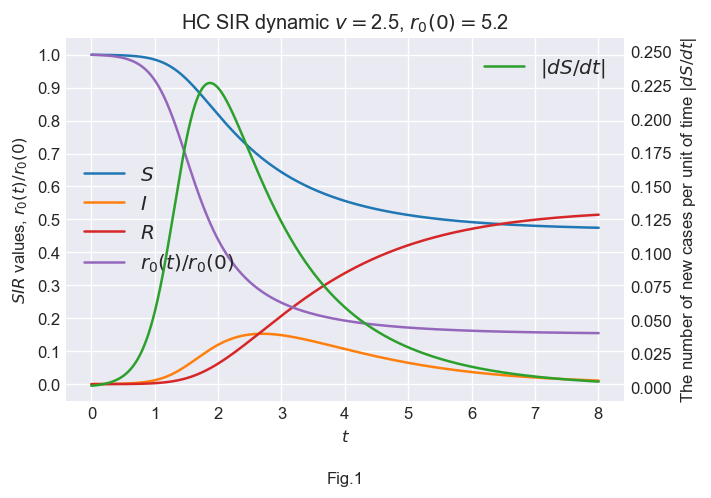

R+I at max |dS/dt| is 0.1527705866122323.


In [4]:
v0=2.5
r0_0=5.2
I0=0.0002
S,I,R,dS= HC_SIR(r0_0,I0,v0)

fig, ax = plt.subplots(dpi=120)
plt.plot(m_t, S, color='C0', label=f'$S$')
plt.plot(m_t, I,color='C1', label=f'$I$')
plt.plot(m_t, R,color='C3', label=f'$R$')
plt.plot(m_t, dS/(I*S)/r0_0,color='C4', label=f'$r_0(t)/r_0(0)$')
ax.set_ylim([-0.05,1.05])
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.set_ylabel(f'$SIR$ values, $r_0(t)/r_0(0)$')
plt.legend(loc='center left')
plt.xlabel(f'$t$')
ax2 = ax.twinx()
plt.plot(m_t, dS, color='C2', label=f'$|dS/dt|$') 
ax2.set_ylim([-0.01,0.26])
ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.025))
ax2.grid(False)
ax2.set_ylabel(f'The number of new cases per unit of time $|dS/dt|$')
plt.legend(loc='upper right')
plt.title(f'HC SIR dynamic $v=${v0}, $r_0(0)=${r0_0}')
ax.text(4,-.3, 'Fig.1', ha='center')
plt.show() 
print(f'R+I at max |dS/dt| is {(R+I)[np.argmax(dS)]}.')


To store the results for further comparisons we create a simple dataclass.

In [5]:
@dataclass
class SIR_solution:
    S:np.ndarray
    I:np.ndarray
    R:np.ndarray
    dS:np.ndarray

HC_dynamics=SIR_solution(S,I,R,dS)

Before heterogeneity of spreading the disease modelling we describe (log normally distributed) total heterogeneity in ability of getting infected among susceptible population as a combination of "social" (denoted by $s$ subscript) and "biological" (denoted by $b$ subscript) parts.

This way previosly used the univariate lognormal distribution of scalar variable $h$ described by evolving parameters $\mu,v$ becomes a bivariate lognormal distribution of vector variable $\mathbf{h}=(h_s,h_b)$ described by evolving parameters $\mu_s,\mu_b,C,v_s,v_b$ and $h=h_s h_b$. Here C is the covariance of $\ln(h_s)$ and $\ln(h_b)$.  The joint probability density function for $h_s,h_b$ is:

$$
    f(h_s,h_b) =
      \frac{1}{2 \pi h_s h_b \sqrt{(1-\rho^2)v_s v_b}} \\
      \cdot\exp\left(
        -\frac{1}{(1-\rho^2)}\left[
          \frac{(\ln(h_s)-\mu_s)^2}{2v_s} +
          \frac{(\ln(h_b)-\mu_b)^2}{2v_b} -
          \frac{C(\ln(h_s)-\mu_s)(\ln(h_b)-\mu_b)}{v_s v_b}
        \right]
      \right)
$$

where $\rho^2=\frac{C^2}{v_s v_b}$ - the square of the (logarithmic) correlation coefficient.

Using reasoning similar to that in the previous part, and more complex mathematics, new equations are obtained that describe the dynamics of "social" and "biological" heterogeneity of the susceptible population ability to become infected. 
$$\begin{align}
& r_0= \alpha\, M(\mu_s,\mu_b,C,v_s,v_b), \\[3pt]
& \frac{d S}{dt}=- r_0 I\,S, \\[3pt]
& \frac{dI}{dt} =- \frac{dS}{dt}- I,\\[3pt]
& \frac{d\mu_s}{dt}=- r_0 I\,(C+v_s), \\[3pt]
& \frac{d\mu_b}{dt}=- r_0 I\,(C+v_b), \\[3pt]
& \frac{dC}{dt}=- r_0 I\,(C+v_s)\,(C+v_b), \\[3pt]
& \frac{d v_s}{dt}=-r_0 I\,(C+v_s)^2, \\[3pt]
& \frac{d v_b}{dt}=-r_0 I\,(C+v_b)^2, \\[3pt]
&R = 1-S-I 
\end{align}$$

$$I(0)=I_0,\:S(0)=1-I_0,\:\mu_s(0)=\mu_b(0)=C(0)=0 \\ v_s(0)+v_b(0)=v_0,\: \alpha=\frac{r_0(0)}{M(0,0,0,v_s,v_b)}$$ 
where $M(\mu_s,\mu_b,C,v_s,v_b)$ - expectation of bivariate lognormal variable
$M(\mu_s,\mu_b,C,v_s,v_b)=\exp(\mu_s+\mu_b+C+(v_s+v_b)/2)$

If we denote the sum $\mu_s+\mu_b$ as $\mu$ and $2C+v_s+v_b$ as $v$ we get exactly previos  HC SIR system.

In [6]:
def HC_SIR2(r0_0,I0,vs0,vb0):
    α=r0_0/M(0.0,vs0+vb0)
    
    def ODE(y,t):
        S,I,mus,mub,C,vs,vb=y
        Cpvs=C+vs
        Cpvb=C+vb 
        minus_r0_mult_I=-α*M(mus+mub,Cpvs+Cpvb)*I

        dS = minus_r0_mult_I*S
        dI = -dS - I
        dmus = minus_r0_mult_I*Cpvs
        dmub = minus_r0_mult_I*Cpvb
        dC = dmus*Cpvb
        dvs = dmus*Cpvs
        dvb = dmub*Cpvb
        return [dS, dI, dmus,dmub,dC,dvs,dvb]
    
    y0=[1.0-I0,I0,0.0,0.0,0.0,vs0,vb0]
    
    sol = odeint(ODE,y0, m_t).T
    dS=-ODE(sol,m_t)[0]
    S,I,R=sol[0],sol[1],1.0-sol[0]-sol[1]
    C=sol[-3]
    vs=sol[-2]
    vb=sol[-1]
    return S,I,R,dS,C,vs,vb

And the result is

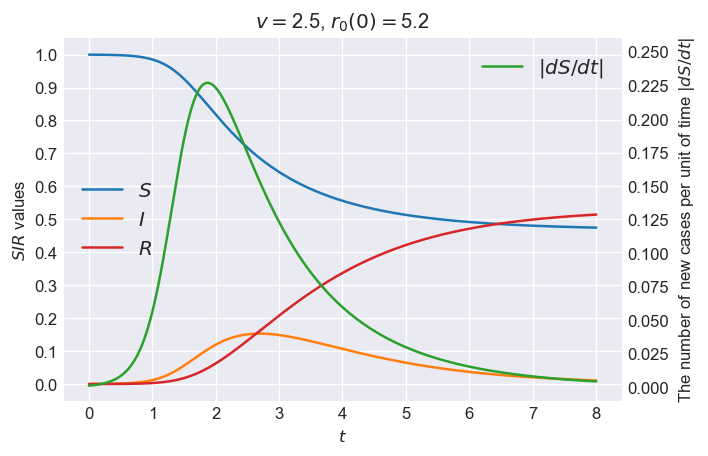

In [7]:
vs0=1.3
vb0=v0-vs0
S,I,R,dS,C,vs,vb= HC_SIR2(r0_0,I0,vs0,vb0)

fig, ax = plt.subplots(dpi=120)
plt.plot(m_t, S, color='C0', label=f'$S$')
plt.plot(m_t, I,color='C1', label=f'$I$')
plt.plot(m_t, R,color='C3', label=f'$R$')
ax.set_ylim([-0.05,1.05])
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.set_ylabel(f'$SIR$ values')
plt.legend(loc='center left')
plt.xlabel(f'$t$')
ax2 = ax.twinx()
plt.plot(m_t, dS, color='C2', label=f'$|dS/dt|$') 
ax2.set_ylim([-0.01,0.26])
ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.025))
ax2.grid(False)
ax2.set_ylabel(f'The number of new cases per unit of time $|dS/dt|$')
plt.legend(loc='upper right')
plt.title(f'$v=${v0}, $r_0(0)=${r0_0}')

plt.show() 

Exactly the same as in fig. 1, but we can see relative dynamic of social and biological heterogeneity

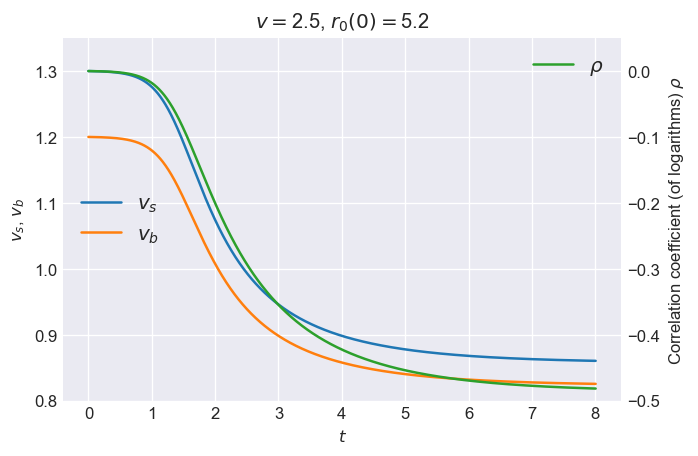

In [8]:
fig, ax = plt.subplots(dpi=120)
plt.plot(m_t, vs, color='C0', label=f'$v_s$')
plt.plot(m_t, vb,color='C1', label=f'$v_b$')
ax.set_ylim([0.8,1.35])
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.set_ylabel(f'$v_s$, $v_b$')
plt.legend(loc='center left')
plt.xlabel(f'$t$')
ax2 = ax.twinx()
plt.plot(m_t, C/np.sqrt(vs*vb), color='C2', label=f'$ρ$') 
ax2.set_ylim([-0.5,0.05])
#ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.02))
ax2.grid(False)
ax2.set_ylabel(f'Correlation coefficient (of logarithms) $ρ$')
plt.legend(loc='upper right')
plt.title(f'$v=${v0}, $r_0(0)=${r0_0}')

plt.show() 

It is interesting to note that social and biological heterogeneity becomes more and more anti-correlated over time. A person with a high social ability to pick up a disease can remain uninfected for a long time only if his biological ability to become infected is low and vice versa. Thus, as time goes on the distribution of social and biological ability to become infected among still non-infected people should become more anti-correlated.

If a person with a high social ability to pick up a disease becomes infected, then he, at least for some time, becomes a person with a high social ability to spread the disease. Thus, the social ability to become infected and spread disease flows from the uninfected to the infected as the infection progresses. A decrease in the total social ability to get infected among the susceptible part of the population is accompanied by a similar increase (among the infected part of the population) in the total social ability to infect. 

Total social ability to get infected among the susceptible part of the population is a product of everage social ability to get infected among the susceptible part of the population $M_s=M(\mu_s,v_s)=\exp(\mu_s+v_s/2)$ and a portion of susceptible population — $S$. So if we denote as $A$ (from activity) the total social ability to infect we get for its dynamic inflow term
$$\frac{dA}{dt}=-\frac{d(M_s S)}{dt}- \text{[outflow term]}$$

For some time we will not worry about the decay of a person's social ability to infect as the disease progresses. We will assume that this decay does not affect the heterogeneity of the distribution, and is taken into account by multiplying by the corresponding constant. The decay can be more correctly handled, say, by dividing the infected part of the population $I$ into not yet having serious symptoms and spreading the disease with the full extent of their social activity $I_l$ and having already reduced social activity due to the manifestation of symptoms $I_h$.

Let's get down to $A$ outflow term. The total social ability to infect reduces as long as infected persons recovered. The population outflow from infected to recovered is described by second term in the right side of the equation:
$$\frac{dI}{dt} =- \frac{dS}{dt}- I$$
Each convalescent takes with him a corresponding portion of the social capacity to infect. Since the order of recovery does not necessarily coincide with the order of illness, we assume that the total share of the social ability to infect taken away by the recovering is simply the product of the average social ability to infect by the number of recoveries. Everage social ability to infect is $a=A/I$ the recoveries outflow is $I$, so outflow term we are looking for is $a\cdot I=A$. That means
$$\frac{dA}{dt}=-\frac{d(M_s S)}{dt}- A$$

Now let's take a closer look at the equation
$$\frac{d S}{dt}=- r_0 I\,S$$

It describes the fact that infectious agents infect susceptible individuals at an intensity determined by the coefficient $r_0$. This coefficient should be equal, up to some constant, to the product of the average ability to get infected — $M$ and the average ability to spread the infection — $a$:

$$r_0=\alpha M a$$

and susceptible part dynamics is given by:
$$\frac{d S}{dt}=- \alpha M\, a\, I\,S=- \alpha M \frac{A}{I} I\,S=- \alpha M\, A\,S$$

As a result we get the system:
$$\begin{align}
& M =  \exp(\mu_s+\mu_b+C+(v_s+v_b)/2), \\[3pt]
& M_s =  \exp(\mu_s+v_s/2), \\[3pt]
& \frac{d S}{dt}=- \alpha M A\,S, \\[3pt]
& \frac{dI}{dt} =- \frac{dS}{dt}- I,\\[3pt]
& \frac{dA}{dt} =- \frac{d(M_s S)}{dt}- A,\\[3pt]
& \frac{d\mu_s}{dt}=- \alpha M A\,(C+v_s), \\[3pt]
& \frac{d\mu_b}{dt}=- \alpha M A\,(C+v_b), \\[3pt]
& \frac{dC}{dt}=- \alpha M A\,(C+v_s)\,(C+v_b), \\[3pt]
& \frac{d v_s}{dt}=-\alpha M A\,(C+v_s)^2, \\[3pt]
& \frac{d v_b}{dt}=-\alpha M A\,(C+v_b)^2, \\[3pt]
&R = 1-S-I 
\end{align}$$

Don't be afraid of the system size, the system can be made much shorter by some substitutions, but the meaning of new variables will be quite opaque.

Now it's time for $d(M_s S)/dt$ term:

$$
\begin{equation}
\begin{matrix}
&\frac{d(M_s S)}{dt}=\frac{dM_s}{dt} S+M_s\frac{dS}{dt}\\
&=\frac{d(\exp(\mu_s+v_s/2))}{dt} S+M_s\frac{d S}{dt}\\
&=M_s(\frac{d\mu_s}{dt}+\frac{1}{2}\frac{dv_s}{dt})S+M_s\frac{d S}{dt}\\
&=M_s ((C+v_s)+\frac{1}{2}(C+v_s)^2)\alpha M A S+M_s\frac{dS}{dt}\\ 
&=M_s(1+(C+v_s)+\frac{1}{2}(C+v_s)^2)\frac{dS}{dt}
\end{matrix}
\end{equation}
$$

>The sum $1+(C+v_s)+\frac{1}{2}(C+v_s)^2$ looks like truncated Taylor expansion of the exponent $\exp(C+v_s)$. And this is not coincidence. Another way of reasoning is to calculate inflow term directly. Given probability distribution $f(h_s,h_b)$ discussed above, the inflow term is $\alpha A S\cdot E[h_s^2h_b] =M_s\exp(C+v_s)\dot S$. We don't use this form of the term because it is the therm from "exact" model  and this form of the term does not fit to our approximate model. 

Let denote $M_s(1+(C+v_s)+\frac{1}{2}(C+v_s)^2)$ as $a_s(\mu_s,C,v_s)$ or just $a_s$ then:
$$\frac{d(M_s S)}{dt}=a_s\frac{dS}{dt}$$

The tricky part is choosing the correct starting value for $ A $ — $ A_0 $. I initialize it as a product
$$ A_0 = a_s (0) \cdot I_0 = M_s(0)\left(1 + v_s (0) + \frac {v_s ^ 2 (0)} {2}\right)   I_0 $$

That choice makes the average ability of the infection spreading at the initial moment $ a(0)=A_0 / I_0 $ exactly equal to $ a_s (0) $. There is also arguments based on initial dynamics to be presented later.

Finally, the system for SIR model with heterogeneity of getting infected and spreading the infection (HCS SIR from now on) together with initial conditions are:
$$\begin{align}
& M =  \exp(\mu_s+\mu_b+C+\frac{1}{2}(v_s+v_b)), \\[3pt]
& M_s =  \exp(\mu_s+\frac{1}{2}v_s), \\[3pt]
& a_s =  M_s(1+(C+v_s)+\frac{1}{2}(C+v_s)^2), \\[3pt]
& \frac{d S}{dt}=- \alpha M A\,S, \\[3pt]
& \frac{dI}{dt} =- \frac{dS}{dt}- I,\\[3pt]
& \frac{dA}{dt} =- a_s\frac{dS}{dt}- A,\\[3pt]
& \frac{d\mu_s}{dt}=- \alpha M A\,(C+v_s), \\[3pt]
& \frac{d\mu_b}{dt}=- \alpha M A\,(C+v_b), \\[3pt]
& \frac{dC}{dt}=- \alpha M A\,(C+v_s)\,(C+v_b), \\[3pt]
& \frac{d v_s}{dt}=-\alpha M A\,(C+v_s)^2, \\[3pt]
& \frac{d v_b}{dt}=-\alpha M A\,(C+v_b)^2, \\[3pt]
&R = 1-S-I 
\end{align}$$

$$I(0)=I_0,\:S(0)=1-I_0,\:\mu_s(0)=\mu_b(0)=C(0)=0,\: \\ v_s(0)=v_{s0},\: v_b(0)=v_{b0},\: \alpha=\frac{r_0(0)}{a_s(0)M(0)},\: A_0=a_s(0)  I_0$$ 

In [9]:
def HCS_SIR(r0_0,I0,vs0,vb0):
    '''
    Heterogeneous in Catching and Spreading
    SIR model
    '''
    def a_s(mus,C,vs):
        Cpvs=C+vs
        return M(mus,vs)*(1.0+Cpvs*(1.0+0.5*Cpvs))
    M0=M(0.0,vs0+vb0)
    a_s0=a_s(0.0,0.0,vs0)
    α=r0_0/M0/a_s0
    
    def ODE(y,t):
        S,I,A,mus,mub,C,vs,vb=y
        Cpvs=C+vs
        Cpvb=C+vb 
        minus_αMA=-α*M(mus+mub,Cpvs+Cpvb)*A

        dS = minus_αMA*S
        dI = -dS - I
        dA= -a_s(mus,C,vs)*dS-A
        dmus = minus_αMA*Cpvs
        dmub = minus_αMA*Cpvb
        dC = dmus*Cpvb
        dvs = dmus*Cpvs
        dvb = dmub*Cpvb
        return [dS, dI,dA, dmus,dmub,dC,dvs,dvb]
    
    A0=a_s0*I0
    y0=[1.0-I0,I0,A0,0.0,0.0,0.0,vs0,vb0]
    
    sol = odeint(ODE,y0, m_t).T
    S,I,A,mus,mub,C,vs,vb=sol
    dS=-ODE(sol,m_t)[0]
    R=1.0-S-I
    return S,I,R,dS

And we can explore the result.

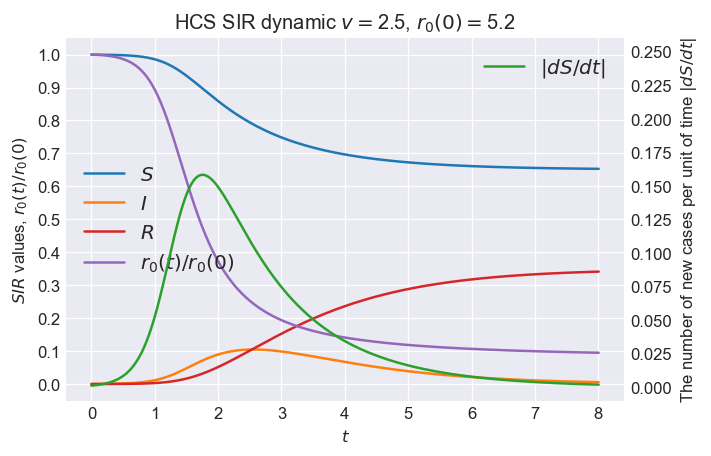

R+I at max |dS/dt| is 0.10328381624202898.


In [10]:
S,I,R,dS= HCS_SIR(r0_0,I0,vs0,vb0)

fig, ax = plt.subplots(dpi=120)
plt.plot(m_t, S, color='C0', label=f'$S$')
plt.plot(m_t, I,color='C1', label=f'$I$')
plt.plot(m_t, R,color='C3', label=f'$R$')
plt.plot(m_t, dS/(I*S)/r0_0,color='C4', label=f'$r_0(t)/r_0(0)$')
ax.set_ylim([-0.05,1.05])
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.set_ylabel(f'$SIR$ values, $r_0(t)/r_0(0)$')
plt.legend(loc='center left')
plt.xlabel(f'$t$')
ax2 = ax.twinx()
plt.plot(m_t, dS, color='C2', label=f'$|dS/dt|$') 
ax2.set_ylim([-0.01,0.26])
ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.025))
ax2.grid(False)
ax2.set_ylabel(f'The number of new cases per unit of time $|dS/dt|$')
plt.legend(loc='upper right')
plt.title(f'HCS SIR dynamic $v=${v0}, $r_0(0)=${r0_0}')

plt.show() 

HCS_dynamics=SIR_solution(S,I,R,dS)

print(f'R+I at max |dS/dt| is {(R+I)[np.argmax(dS)]}.')

Compared to Fig.1 it is worth to note that HCS SIR model predicts more fast $r_0$ declining and lower infection rate. The peak of the infection rate passed early — when around 10% of the population ever been infected, while for HC SIR model it is 15%. 


Now we compare the initial infection rate dynamic for all the models we are considered including SIR and an implied dynamics of 30% daily growth which corresponds to the formula $|dS/dt| \sim\exp(4.2t)$ taking to account that our time unit is 16 days.

To get initial dynamic we fix all parameters at their initial values and consider $S$ being close to one, so we omit it in formulas. For the SIR model it simplifies the equations to

$$
\begin{align}
& \frac{dS}{dt} = - r_0 I, \\[3pt]
& \frac{dI}{dt} = r_0 I- I, \\[3pt]
&I(0)=I_0
\end{align}
$$
It has the solution
$$I(t)=I_0\exp((r_0-1)t),\dot{S}=-r_0I_0\exp((r_0-1)t)$$

For the HC SIR model the simplified equations are:
$$\begin{align}
& \frac{d S}{dt}=- \alpha\, M(0) I, \\[3pt]
& \frac{dI}{dt} = \alpha\, M(0) I- I,\\[3pt]
&I(0)=I_0
\end{align}$$
As we choose $\alpha =r_0/M(0)$ so $r_0 =\alpha M(0)$ the solution is the same
$$I(t)=I_0\exp((r_0-1)t),\dot{S}=-r_0(0)I_0\exp((r_0-1)t)$$

And finally, initial dynamics HCS SIR equations:
$$\begin{align}
& \frac{d S}{dt}=- \alpha M(0) A, \\[3pt]
& \frac{dI}{dt} =\alpha M(0) A- I,\\[3pt]
& \frac{dA}{dt} =\alpha a_s(0) M(0) A- A,\\[3pt]
&I(0)=I_0,A(0)=a_s(0)I_0
\end{align}$$
As we choose  $\alpha =r_0/(a_s(0)M(0))$ last differential equation becomes $\dot{A} =r_0 A- A$ and the solution for $A$ is $A(t)=A_0\exp((r_0-1)t)=a_s(0)I_0\exp((r_0-1)t)$ substituting to the first equation we get $\dot{S}=-r_0(0)I_0\exp((r_0-1)t)$ and you can check that $I(t)=I_0\exp((r_0-1)t)$ is the solution for the second eqution.

So, taking to account our choice of $\alpha$ and $A_0$ the initial dynamics of all three models should be the same.

Let's check it.

First we get ordinary SIR solution.

In [11]:
def SIR(y,t,r0):
    S,I=y[0],y[1]
    dS = -r0*I*S
    dI= -dS - I
    return [dS, dI]

SIR_y0= [1.0 -I0, I0]

SIR_sol = odeint(SIR,SIR_y0, m_t,(r0_0,)).T
S,I=SIR_sol
SIR_dynamics=SIR_solution(S,I,1.0-S-I,-SIR(SIR_sol,m_t,r0_0)[0])

And comparative starting dynamics...

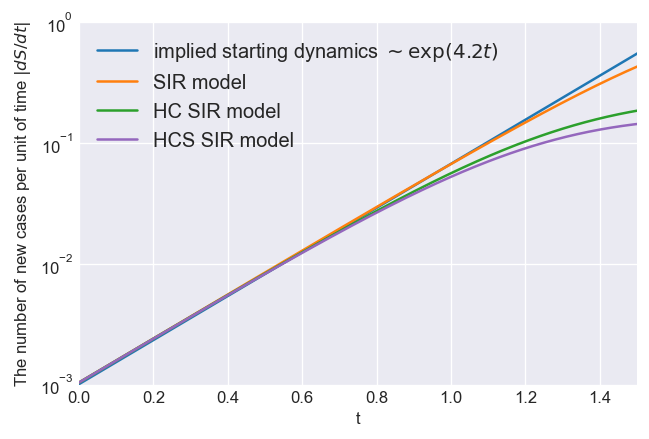

In [12]:
fig, ax = plt.subplots(dpi=120)
plt.plot(m_t,np.exp(4.2*m_t-6.9), color='C0', label=f'implied starting dynamics $\sim \exp(4.2t)$')
plt.plot(m_t,SIR_dynamics.dS, color='C1', label=f'SIR model')
plt.plot(m_t,HC_dynamics.dS, color='C2', label=f'HC SIR model')
plt.plot(m_t,HCS_dynamics.dS, color='C4', label=f'HCS SIR model')
ax.set_ylabel(f'The number of new cases per unit of time $|dS/dt|$')
ax.set_ylim([0.001,1])
ax.set_xlim([0.0,1.5])
plt.yscale('log')
plt.legend(loc='upper left')
plt.xlabel(f't')
plt.show() 


Next we draw PIP (persentage of the infected population at infection rate peak) dependencies on $v_s$ and $v_b$. Both $v_s$ and $v_b$ are in range [0.8,1.8]. First collect the values form uniform grid:

In [13]:
def PIPF(r0,I0):
    def F(v):
        S,_,_,dS=HCS_SIR(r0,I0,*v)
        return 100.0-100.0*S[np.argmax(dS)]
    return F
v_min=0.8
v_max=1.8
axis_range=np.linspace(v_min, v_max, 41)
Vs, Vb = np.meshgrid(axis_range, axis_range)

#to get PIP more pricise we use smaller step and modelling length of 3 time units is enough
m_t=np.arange(0.0, 3.0, t_step*.1,dtype=np.float64) 
PIP=np.apply_along_axis(PIPF(r0_0,I0),0,[Vs,Vb])


Next, draw them as a map

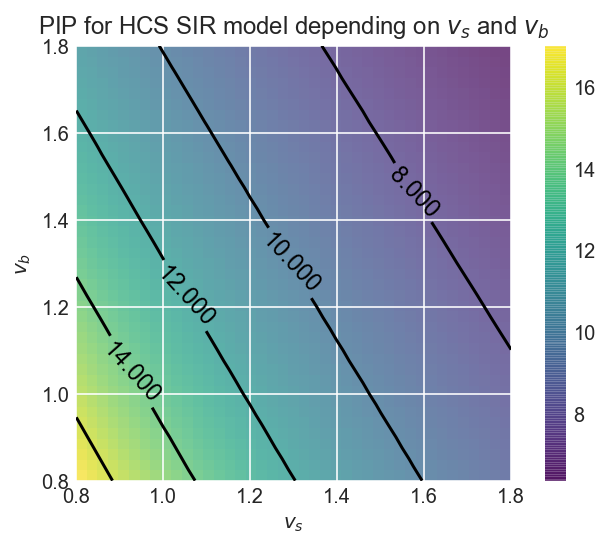

In [14]:
fig, ax = plt.subplots(dpi=144)
contours = plt.contour(Vs, Vb, PIP, 5, colors='black')
plt.clabel(contours, inline=True, fontsize=12)
ax.set_xlabel(f'$v_s$')
ax.set_ylabel(f'$v_b$')

plt.imshow(PIP, extent=[v_min,v_max, v_min,v_max], origin='lower',
           cmap='viridis', alpha=0.7)
plt.colorbar();
plt.title(f'PIP for HCS SIR model depending on $v_s$ and $v_b$')
plt.show()

Let's make this image more informative placing values of ratio top 10% bound to bottom 10% bound for appropriate $v$ along the axes. We need a function for the ratio calculation.

In [15]:
range0901=scst.norm.ppf(0.9)-scst.norm.ppf(0.1)
def get_range(v):
    σ=np.sqrt(v)
    return np.exp(range0901*σ)

Using the function transform the grid to the "ratio" domain and interpolate the values to new uniform grid in this domain 

In [16]:
PIP_interpolator=scint.Rbf(get_range(Vs), get_range(Vb), PIP,smooth=1)

r_min=get_range(v_min)
r_max=get_range(v_max)
NperAx=200
r_axis_range=np.linspace(r_min,r_max,NperAx)
Rs, Rb = np.meshgrid(r_axis_range, r_axis_range)
rPIP=np.zeros((NperAx,NperAx))
for i in range(NperAx):
    for j in range(NperAx):
        rPIP[i,j]=PIP_interpolator(Rs[i,j],Rb[i,j])

Finally, draw the result

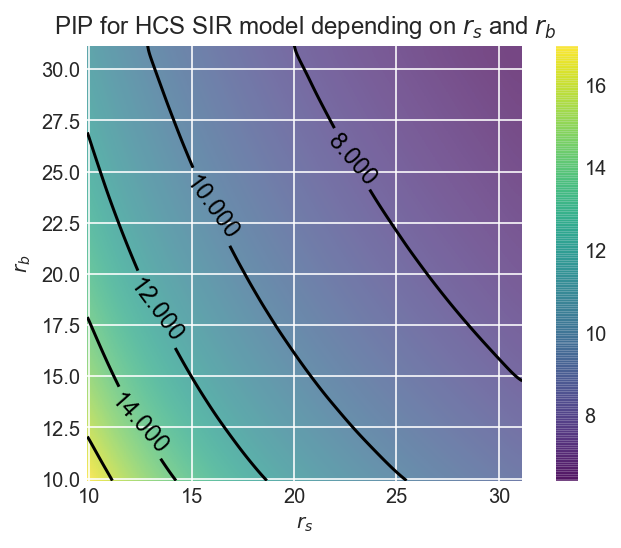

In [17]:
fig, ax = plt.subplots(dpi=144)
contours = plt.contour(Rs, Rb, rPIP, 5, colors='black')
plt.clabel(contours, inline=True, fontsize=12)
ax.set_xlabel(f'$r_s$')
ax.set_ylabel(f'$r_b$')

plt.imshow(rPIP, extent=[r_min,r_max, r_min,r_max], origin='lower',
           cmap='viridis', alpha=0.7)
plt.colorbar();
plt.title(f'PIP for HCS SIR model depending on $r_s$ and $r_b$')
plt.show()

Next interesting relationship is the relationship between PIP and the final percentage of the population never infected (FPNI). As FPNI value we use percentage of never infected population after 100 time units.

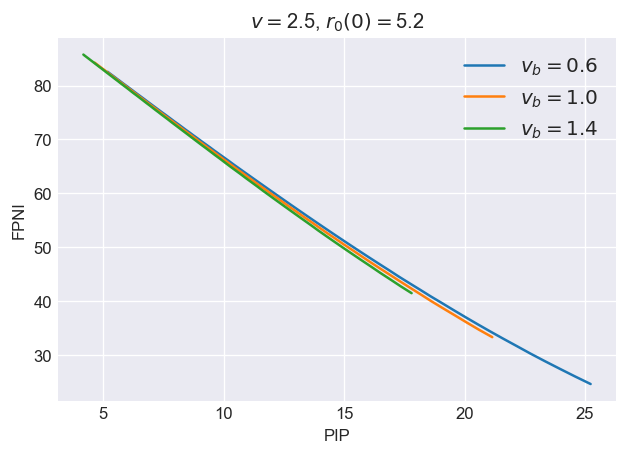

In [18]:
def PIP_FPNIfunc(r0,I0,vb0):
    def f(v):
        S,_,_,dS=HCS_SIR(r0,I0,v,vb0)
        return 100.0-100.0*S[np.argmax(dS)],100.0*S[-1]
    return f
#small step and short modelling interval to get PIP
m_t1=np.arange(0.0, 3.0, t_step*.1,dtype=np.float64)
#big step and long modelling interval to get FPNI
m_t2=np.arange(t_step*.05, 100.0, t_step*10.0,dtype=np.float64)
#final modelling times
m_t=np.sort(np.concatenate((m_t1,m_t2)))

fig, ax = plt.subplots(dpi=120)
for vb in [0.6,1.0,1.4]:
    plt.plot(*np.vectorize(PIP_FPNIfunc(r0_0,I0,vb))(np.linspace(0.4, 3.0, 80)),  
             label=f'$v_b={vb}$')
ax.set_ylabel(f'FPNI')
plt.legend(loc='center left')
plt.xlabel(f'PIP')
plt.legend(loc='upper right')
plt.title(f'$v=${v0}, $r_0(0)=${r0_0}')

plt.show() 


As we can see, the relationship is insignificantly dependant on $v_b$. So, although it is hard to measure real values of social and biological heterogeneity, possibly, PIP value can be the integral heterogeneity estimation indicating, among other things, the final proportion of ever been infected and uninfected.

Let's choose $v_b$, say, to be one and explore the relation little bit more.

In [19]:
PIP,FPNI=np.vectorize(PIP_FPNIfunc(r0_0,I0,1.0))(np.linspace(0.4, 4.0, 200))
scst.linregress(PIP,FPNI)

LinregressResult(slope=-3.2047344395170305, intercept=98.9705471935763, rvalue=-0.9994763802104987, pvalue=5.328254625367594e-297, stderr=0.007373150216952505)

Roughly speaking, having PIP one percent fewer saves 3.2% percent population uninfected.

Let me remind you that all of the above models do not include public measures and change in individual behavior as the epidemic develops.